# 1. Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
import geopandas as gpd

# 2. Loading & Inspecting the Data

In [3]:
df = pd.read_csv("Dataset/Retail_Prices_of _Products.csv")

In [4]:
df.head()

,Year,Month,GEO,Product Category,Products,VALUE,Taxable,Total tax rate,Value after tax,Essential,COORDINATE,UOM
0,2017,January,Province 1,Meat & Poultry,"Beef stewing cuts, per kilogram",12.66,No,11.0,12.66,Essential,11.10,Dollars
1,2017,January,Province 1,Meat & Poultry,"Beef striploin cuts, per kilogram",21.94,No,11.0,21.94,Essential,11.20,Dollars
2,2017,January,Province 1,Meat & Poultry,"Beef top sirloin cuts, per kilogram",13.44,No,11.0,13.44,Essential,11.30,Dollars
3,2017,January,Province 1,Meat & Poultry,"Beef rib cuts, per kilogram",20.17,No,11.0,20.17,Essential,11.41,Dollars
4,2017,January,Province 1,Meat & Poultry,"Ground beef, per kilogram",9.12,No,11.0,9.12,Essential,11.40,Dollars


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118482 entries, 0 to 118481
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Year              118482 non-null  int64  
 1   Month             118482 non-null  object 
 2   GEO               118482 non-null  object 
 3   Product Category  118482 non-null  object 
 4   Products          118482 non-null  object 
 5   VALUE             118482 non-null  float64
 6   Taxable           118482 non-null  object 
 7   Total tax rate    118482 non-null  float64
 8   Value after tax   118482 non-null  float64
 9   Essential         118482 non-null  object 
 10  COORDINATE        118482 non-null  float64
 11  UOM               118482 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 10.8+ MB


In [6]:
df.describe()

,Year,VALUE,Total tax rate,Value after tax,COORDINATE
count,118482.000000,118482.000000,118482.000000,118482.000000,118482.000000
mean,2020.591837,5.437324,12.632134,5.515499,6.501741
std,2.355363,5.192748,2.899124,5.215311,3.172173
min,2017.000000,0.300000,5.000000,0.300000,1.100000
25%,2019.000000,2.850000,11.000000,2.910000,3.750000
50%,2021.000000,3.990000,13.000000,4.050000,6.500000
75%,2023.000000,5.810000,15.000000,5.947500,9.240000
max,2025.000000,48.450000,15.000000,48.450000,11.990000


# 3. Cleaning & Preparing

In [7]:
df['Date'] = pd.to_datetime(df['Month'] + ' ' + df['Year'].astype(str))
df['Taxable'] = df['Taxable'].astype('category')
df['Essential'] = df['Essential'].astype('category')
df['Product Category'] = df['Product Category'].astype('category')
df['GEO'] = df['GEO'].astype('category')
df = df.dropna(subset=['VALUE'])
df['Price_Level'] = pd.qcut(df['VALUE'], q=3, labels=['Low', 'Medium', 'High'])
df['Month_num'] = df['Date'].dt.month
df['Year_num'] = df['Date'].dt.year

# 4. EDA 

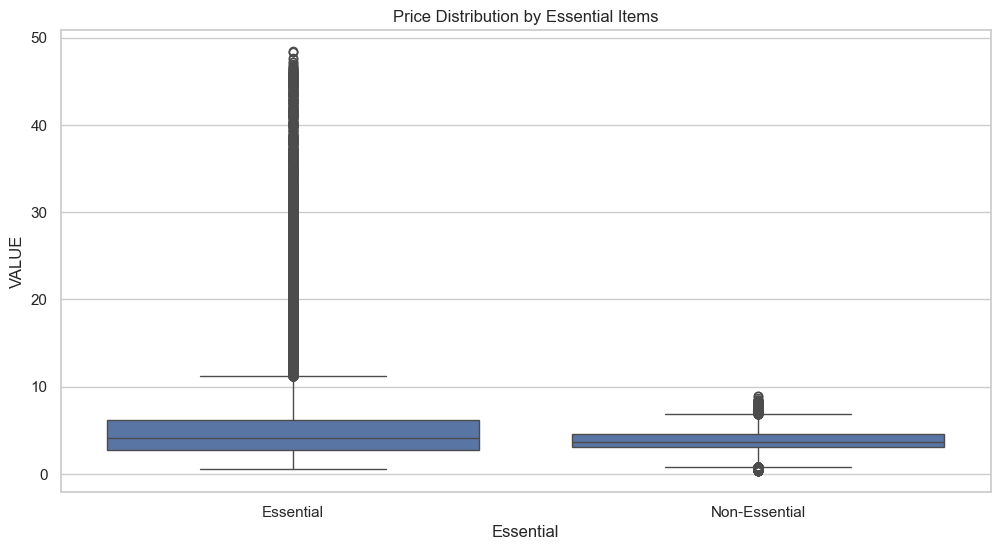

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
sns.boxplot(x='Essential', y='VALUE', data=df)
plt.title('Price Distribution by Essential Items')
plt.show()


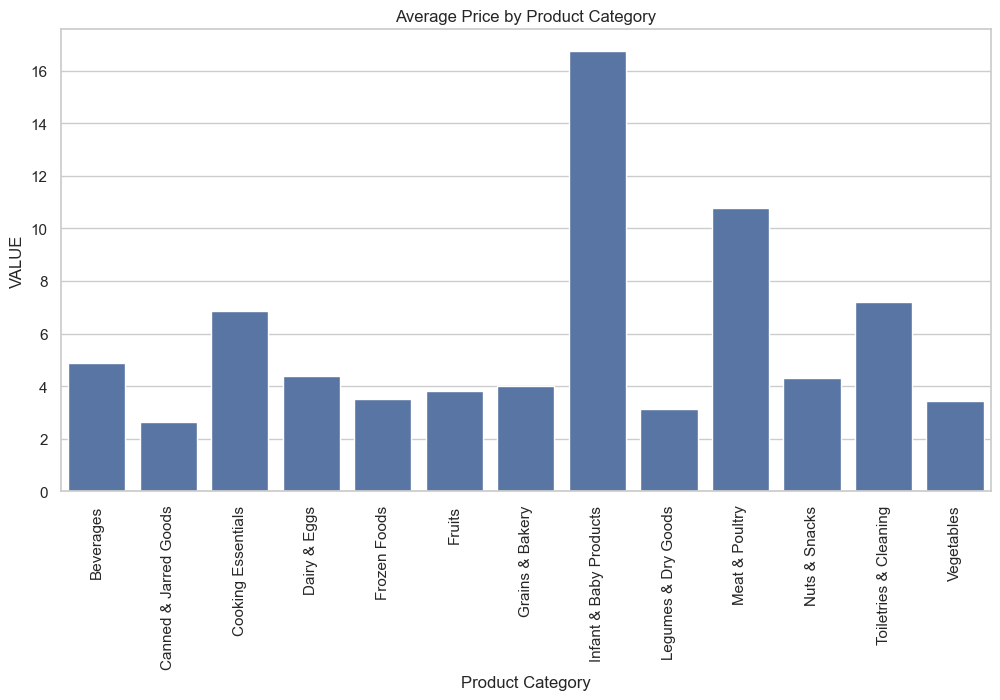

In [9]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x='Product Category', y='VALUE', ci=None)
plt.xticks(rotation=90)
plt.title('Average Price by Product Category')
plt.show()

# 5. Price Trend Analysis (Time Series)

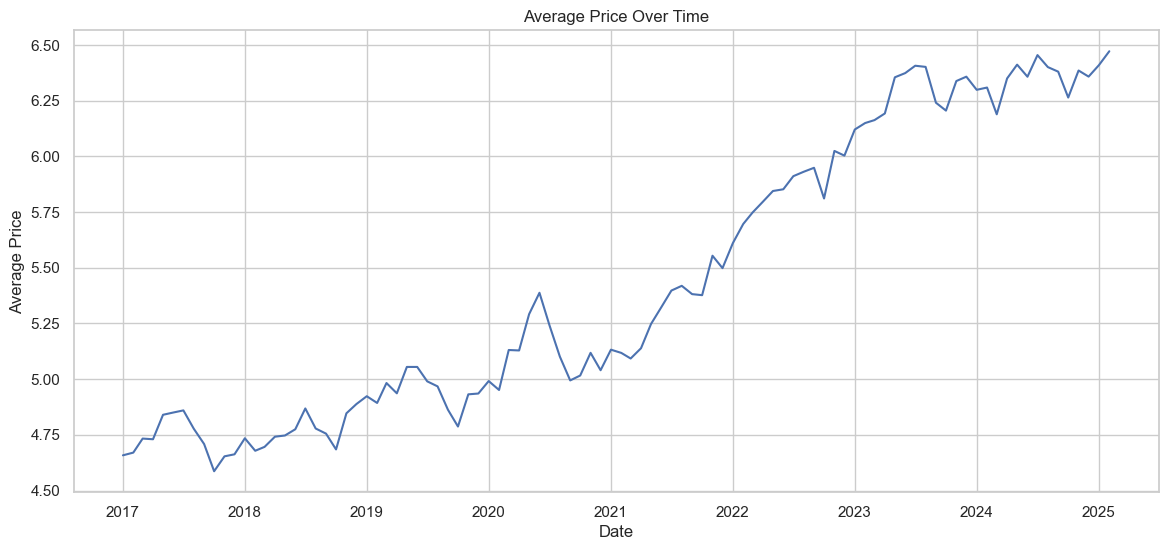

In [10]:
avg_monthly = df.groupby('Date')['VALUE'].mean().reset_index()
plt.figure(figsize=(14,6))
sns.lineplot(data=avg_monthly, x='Date', y='VALUE')
plt.title('Average Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.show()

# 6. Category-wise Price Comparison

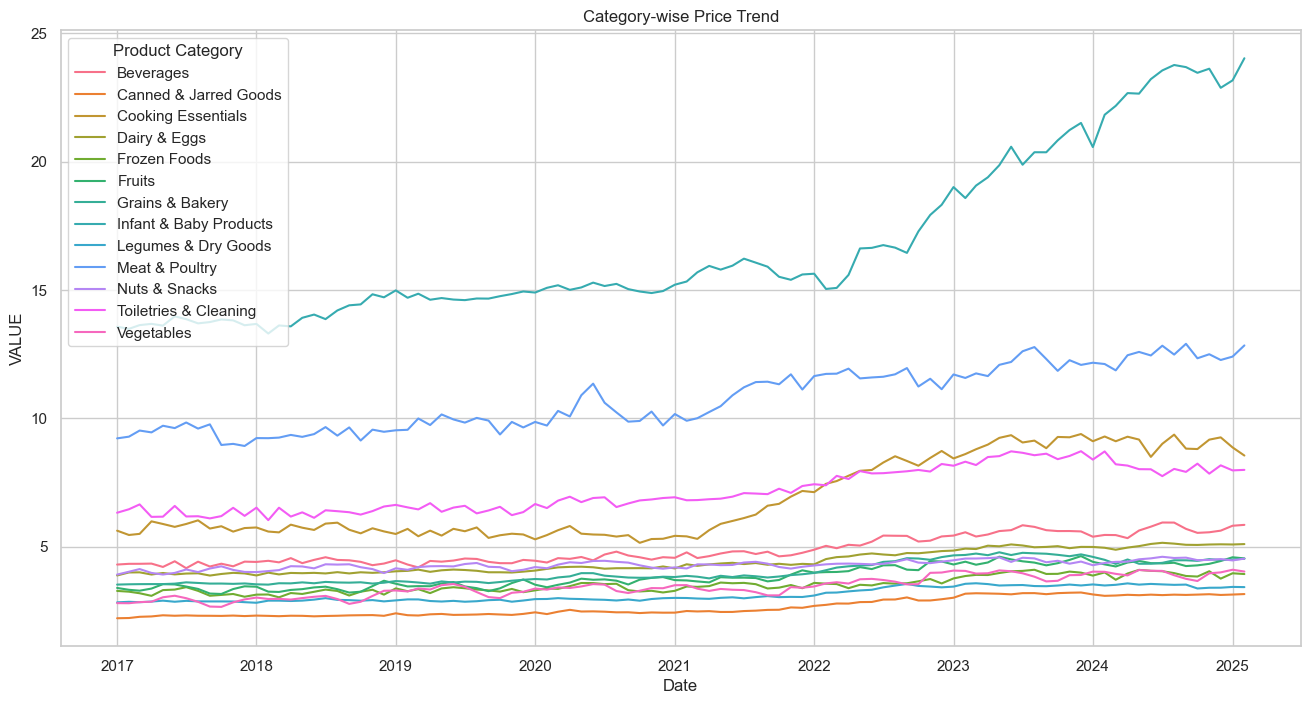

In [11]:
cat_month = df.groupby(['Date','Product Category'])['VALUE'].mean().reset_index()
plt.figure(figsize=(16,8))
sns.lineplot(data=cat_month, x='Date', y='VALUE', hue='Product Category')
plt.title('Category-wise Price Trend')
plt.show()

# 7. Anomaly Detection

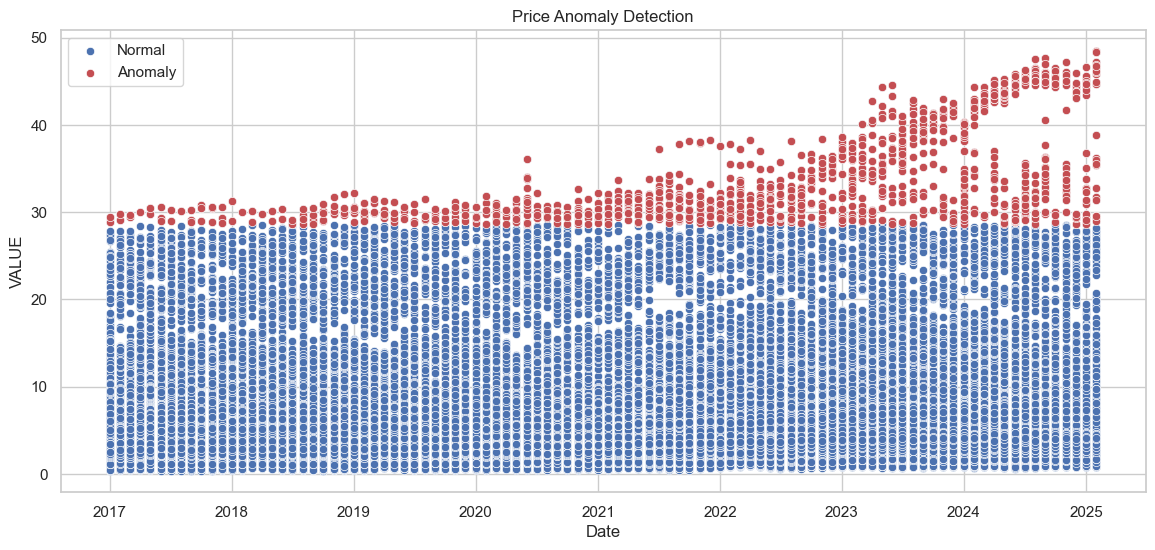

In [12]:
iso = IsolationForest(contamination=0.01)
df['anomaly'] = iso.fit_predict(df[['VALUE']])
anomalies = df[df['anomaly'] == -1]
plt.figure(figsize=(14,6))
sns.scatterplot(data=df, x='Date', y='VALUE', label='Normal')
sns.scatterplot(data=anomalies, x='Date', y='VALUE', color='r', label='Anomaly')
plt.title('Price Anomaly Detection')
plt.legend()
plt.show()

# 8. Regression Modeling

In [15]:
reg_data = df[['VALUE', 'Taxable', 'Essential', 'Product Category', 'GEO', 'Month_num', 'Year_num']].copy()
reg_data = pd.get_dummies(reg_data, drop_first=True)
X_reg = reg_data.drop(columns=['VALUE'])
y_reg = reg_data['VALUE']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
reg_model = LinearRegression()
reg_model.fit(X_train_r, y_train_r)
y_pred_r = reg_model.predict(X_test_r)
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_test_r, y_pred_r)
print("Linear Regression RMSE:", np.sqrt(rmse))
print("Linear Regression R2 Score:", r2_score(y_test_r, y_pred_r))

Linear Regression RMSE: 4.007823143783731
Linear Regression R2 Score: 0.38819888825565796


# 9. Classification Modeling

In [ ]:


le = LabelEncoder()
y = le.fit_transform(df['Price_Level'])  # Converts 'Low', 'Medium', 'High' to 0, 1, 2

X = df.drop(columns=['VALUE', 'Value after tax', 'Total tax rate', 'Date', 'Products', 'Price_Level', 'Month', 'Year'])
y = df['Price_Level']
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(),
    LGBMClassifier(),

]

for model in models:
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    print(f"\nModel: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


Model: LogisticRegression
Accuracy: 0.5945056336245095
Classification Report:
               precision    recall  f1-score   support

        High       0.74      0.65      0.69      7885
         Low       0.55      0.68      0.61      7948
      Medium       0.52      0.46      0.49      7864

    accuracy                           0.59     23697
   macro avg       0.60      0.59      0.59     23697
weighted avg       0.60      0.59      0.59     23697

Confusion Matrix:
 [[5090 1273 1522]
 [ 702 5382 1864]
 [1117 3131 3616]]
Classification Report:
               precision    recall  f1-score   support

        High       0.74      0.65      0.69      7885
         Low       0.55      0.68      0.61      7948
      Medium       0.52      0.46      0.49      7864

    accuracy                           0.59     23697
   macro avg       0.60      0.59      0.59     23697
weighted avg       0.60      0.59      0.59     23697

Confusion Matrix:
 [[5090 1273 1522]
 [ 702 5382 1864]
 [111